## 3.3 Course Review Classifier Modeling

This notebook demonstrate the machine learning models classifying good reviews and bad reviews using the review textual data as input.

### Import basic libraries

In [1]:
# the basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_colwidth = 350

In [2]:
#import preprocessing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [3]:
# import modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

### Import data

In [4]:
# the data is scraped from Coursera.org using the codes from notebook 01.1
path = '../data/reviews_ml_modeling.csv'
reviews = pd.read_csv(path)

In [5]:
# quick pre-processing, dropping columns and remove rows with null values
reviews.drop(columns=['Unnamed: 0'], inplace=True)
reviews.dropna(inplace=True)

In [6]:
# reviews.shape

In [7]:
# reviews.head(1)

### Preliminary Modeling

In [8]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

#### Setting up X and y

In [9]:
# feature selection
ignore_cols = ['review', 'date_of_review', 'rating', 'course_href', 'review_is_bad', 'review_clean']
features = [c for c in reviews.columns if c not in ignore_cols]

In [10]:
X = reviews[features]
y = reviews['review_is_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [11]:
# baseline
y.value_counts(normalize=True)

0    0.968687
1    0.031313
Name: review_is_bad, dtype: float64

In [12]:
# Set up a list to contain pipelines
pipelines = []

# Set up tuples for all the models we want to test
models = [('logic', LogisticRegression(solver='liblinear')),
         ('dtr', DecisionTreeClassifier()),
         ('rfr', RandomForestClassifier())]

# Set up pipelines for all the models alone and with StandardScaler
for model in models:
    pipelines.append(Pipeline([('ss', StandardScaler()),
                              model]))

In [13]:
# this function takes a list of pipelines and return their R2 and RMSE scores 
def pipe_evaluations(pipelines):
    evaluations = []

# Loop through and fit all the pipelines
    for pipe in pipelines:
        pipe.fit(X_train, y_train)

        evaluations.append({
            'Pipeline': [step[0] for step in pipe.steps],
            'Accuracy (train)': pipe.score(X_train, y_train),
            'Accuracy (test)': pipe.score(X_test, y_test)
        })

    # add evaluation metrics to a dataframe
    evaluations_df = pd.DataFrame(evaluations)
    return evaluations_df

In [14]:
# evaluation the pipelines
pipe_evaluations(pipelines)

,Pipeline,Accuracy (train),Accuracy (test)
0,"[ss, logic]",0.997721,0.937850
1,"[ss, dtr]",1.000000,0.949347
2,"[ss, rfr]",1.000000,0.967371


In [15]:
# # check dtypes 
# for each in X.columns:
#     if reviews[each].dtypes == 'float64':
#         print(each)

**Key Takeaway:** the model performance is not out-performing the baseline (the majority class), other techniques are needed for improve the model performance. Nonetheless, I continue with GridSearch to explore whether tuning the hyperparamether can improve the model performance and further understand the important features used in the random forest classifier to understand the problem more.

#### Tuning Random Forest

In [16]:
# without tuning
pipe = Pipeline([('ss', StandardScaler()),
                  ('rfc', RandomForestClassifier())])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(1.0, 0.9676817899316346)

In [17]:
# set up the pipe
pipe = Pipeline([('ss', StandardScaler()),
                  ('rfc', RandomForestClassifier())])

# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [{'rfc__n_estimators':[100, 200],
               'rfc__max_depth':[10,15,20],
               'rfc__min_samples_leaf': [1,2,3]}]

# create a gridsearch of the pipeline, and fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5) 
best_model = gridsearch.fit(X_train,y_train)

# print metrics
print(best_model.best_estimator_)
print('')
print(best_model.score(X_train, y_train), best_model.score(X_test, y_test))

Pipeline(steps=[('ss', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2))])

0.9699544135930377 0.9658172778123058


In [18]:
# train a random forest classifier
rfc = RandomForestClassifier(n_estimators = 100, max_depth=10, random_state = 42)
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9696435971819312, 0.9658172778123058)

In [19]:
# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, 
                                       "importance": rfc.feature_importances_}).sort_values("importance", 
                                        ascending = False)
feature_importances_df.head(10)

,feature,importance
5,compound,0.064866
2,neg,0.061331
0,nb_chars,0.032072
4,pos,0.028617
3,neu,0.023913
1,nb_words,0.021159
1376,word_old,0.019302
1496,word_poor,0.016007
6,doc2vec_vector_0,0.014745
171,word_audio,0.012969


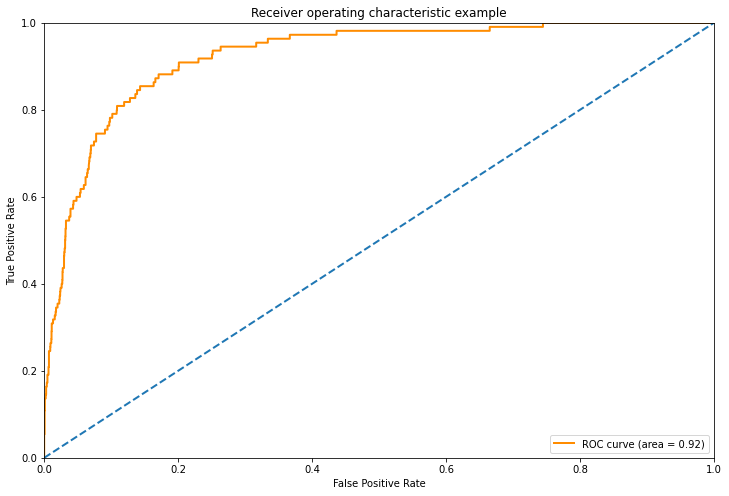

In [20]:
# ROC curve
y_pred = [x[1] for x in rfc.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (12, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Key takeways:** based on the ROC curve, the model performance is acceptable. 

#### Logistic Regression

In [21]:
# without tuning
pipe = Pipeline([('ss', StandardScaler()),
                  ('logic', LogisticRegression(solver='liblinear', penalty='l1'))])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9974098632407791, 0.9577377252952144)

In [22]:
# set up the pipe
pipe = Pipeline([('ss', StandardScaler()),
                 ('logic', LogisticRegression(solver='liblinear', penalty='l1'))])

# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [{'logic__C':[0.1, 0.5, 1]}]

# create a gridsearch of the pipeline, and fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5) 
best_model = gridsearch.fit(X_train,y_train)

# print metrics
print(best_model.best_estimator_)
print('')
print(best_model.score(X_train, y_train), best_model.score(X_test, y_test))

Pipeline(steps=[('ss', StandardScaler()),
                ('logic',
                 LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))])

0.9840447575631993 0.9670602858918583


Accuracy Rate (train): 0.9698508081226689, Accuracy Rate (test): 0.9670602858918583



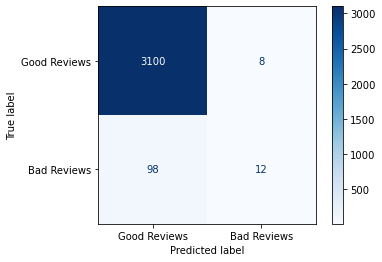

In [34]:
logic = LogisticRegression(solver='liblinear', penalty='l1', C=0.1)
logic.fit(X_train,y_train)
print(f'Accuracy Rate (train): {logic.score(X_train, y_train)}, Accuracy Rate (test): {logic.score(X_test, y_test)}')
print('')
metrics.plot_confusion_matrix(logic, X_test, y_test, cmap='Blues', 
                              values_format='d', display_labels=['Good Reviews', 'Bad Reviews']);

In [37]:
y_true = y_test
y_pred = logic.predict(X_test)
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3108
           1       0.60      0.11      0.18       110

    accuracy                           0.97      3218
   macro avg       0.78      0.55      0.58      3218
weighted avg       0.96      0.97      0.96      3218



In [38]:
# Misclassification Analysis(ACA)
mca_df = reviews.filter(X_test.index, axis=0)
mca_df['true_label'] = y_test
mca_df['predicted_label'] = logic.predict(X_test)
mca_df[(mca_df['true_label']==1)&(mca_df['predicted_label']==0)][['review','true_label','predicted_label']].head(10)

,review,true_label,predicted_label
8,"Been asked to re-take all assignments *after* paying for a certificate! I wil never pay for a Coursera course again, and I would not recommend my friends to do so",1,0
304,Course content was good but i felt few lectures were too boring to constantly concentrate on.,1,0
47,"falta una mejor traducción en los videos ;además que las pruebas y tareas debiesen también debiesen ser traducidos, más al tratarse de lenguaje específico",1,0
400,Good,1,0
386,too academical,1,0
361,Needs improvement on Matlab help\n\n,1,0
181,"Good overview of machine learning. In general focuses more on how to do, but due to course length skipped on some of the how or why in certain topics. Good mentor responses. Lecture video pause points are bugged. Lecture and assignments are quite detailed to walk you through it. Course content not designed to be difficult. Weeks are not very ba...",1,0
290,"A little bit too much math heavy, very theoretical. Nevertheless interesting and great to learn the fundamentals of ML",1,0
354,"The content is useful, but too verbose.",1,0
311,"The course feels a bit outdated, but if you're learning fundamentals, it may be useful.",1,0


In [39]:
y_pred = logic.predict(X_test)

In [40]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
# put the selected features into a DataFrame
coefficients = pd.DataFrame(data=logic.coef_[0], index=X_train.columns, columns=['model_coefficient'])

# list the features of the non-zero coefficients 
coefficients[coefficients['model_coefficient']!=0]

,model_coefficient
nb_chars,-0.006261
nb_words,0.033036
neu,-0.370285
compound,-2.736608
doc2vec_vector_0,0.536975
doc2vec_vector_1,1.299594
doc2vec_vector_2,-0.333712
doc2vec_vector_4,-0.406326


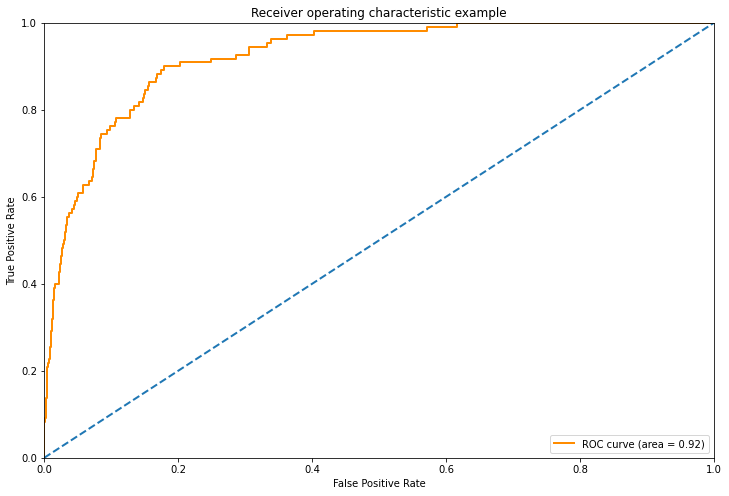

In [42]:
# ROC curve
y_pred = [x[1] for x in logic.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (12, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

---
### Adjusting class imbalance with three basic techniques and modeling with logistic regressions

In [43]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

In [44]:
# recall 
X = reviews[features]
y = reviews['review_is_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [45]:
def print_sampling_stats(X_train_df, X_train_sampled,
                         y_train, y_train_sampled,
                         y_test):
    
    print('Original dataset classes: {}'.format(Counter(y_train)))
    print('Resampled dataset classes: {}'.format(Counter(y_train_sampled)))
    print()
    print('Test dataset classes still the same to model real world: {}'.format(Counter(y_test)))

    print()
    print('X_train shape (under/reg): ', X_train_sampled.shape, X_train.shape)
    print('y_train shape (under/reg): ', y_train_sampled.shape, y_train.shape)
    print('X_test shape, y_test shape: ', X_test.shape, y_test.shape)

#### Undersample More Frequent Class

In [46]:
rus = RandomUnderSampler(random_state=42)

X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print_sampling_stats(X_train, X_train_under,
                     y_train, y_train_under,
                     y_test)

Original dataset classes: Counter({0: 9359, 1: 293})
Resampled dataset classes: Counter({0: 293, 1: 293})

Test dataset classes still the same to model real world: Counter({0: 3108, 1: 110})

X_train shape (under/reg):  (586, 2245) (9652, 2245)
y_train shape (under/reg):  (586,) (9652,)
X_test shape, y_test shape:  (3218, 2245) (3218,)


In [47]:
y_train_under.value_counts(normalize=True)

0    0.5
1    0.5
Name: review_is_bad, dtype: float64

Accuracy Rate (train): 0.8302942395358475, Accuracy Rate (test): 0.8346799254195152



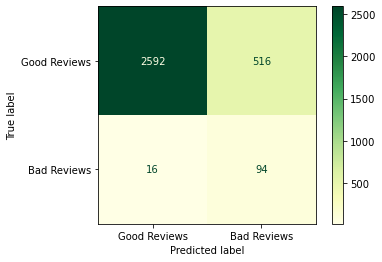

In [48]:
logic = LogisticRegression(solver='liblinear', penalty='l1', C=0.8)
logic.fit(X_train_under,y_train_under)
print(f'Accuracy Rate (train): {logic.score(X_train, y_train)}, Accuracy Rate (test): {logic.score(X_test, y_test)}')
print('')
metrics.plot_confusion_matrix(logic, X_test, y_test, cmap='YlGn', 
                              values_format='d', display_labels=['Good Reviews', 'Bad Reviews']);

In [50]:
y_true = y_test
y_pred = logic.predict(X_test)
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.83      0.91      3108
           1       0.15      0.85      0.26       110

    accuracy                           0.83      3218
   macro avg       0.57      0.84      0.58      3218
weighted avg       0.97      0.83      0.88      3218



In [51]:
# put the selected features into a DataFrame
coefficients = pd.DataFrame(data=logic.coef_[0], index=X_train.columns, columns=['model_coefficient'])

# list the features of the non-zero coefficients 
coefficients[coefficients['model_coefficient']!=0]

,model_coefficient
nb_chars,-0.007143
nb_words,0.047740
pos,0.120230
compound,-3.934279
doc2vec_vector_0,2.256194
doc2vec_vector_1,2.271797
doc2vec_vector_2,-1.184143
doc2vec_vector_3,0.567390
doc2vec_vector_4,-2.233801
word_easy,0.624122


In [52]:
# Misclassification Analysis(ACA)
mca_df = reviews.filter(X_test.index, axis=0)
mca_df['true_label'] = y_test
mca_df['predicted_label'] = logic.predict(X_test)
mca_df[(mca_df['true_label']==0)&(mca_df['predicted_label']==1)][['review','true_label','predicted_label']].head(10)

,review,true_label,predicted_label
840,"A good course so far , it introduces alot the theory about the material , and gives alot of advices on how and when to apply different algorithms , 4 stars because i think that submitting homeworks should be followed by some sort of explanations or solutions to the problems , even tho homworks are a little bit guided !",0,1
2341,"Good quality, one star taken away for the unsteady volume",0,1
2120,I would be much better if it would have included the more layman explanation.,0,1
469,"It is hard, without a doubt, and u most probably will take more time to finish each week, than you can think. But I think this is as complete as it gets. DO NOT depend on this course solely. Go on to Khan Academy and other sites, and learn how the maths work. Although I was familiar with calculus and did a lot of it. Keeping up with all the not...",0,1
451,"Excellent course in machine learning. Reviews key methods and applications, and gives both concepts, application examples, as well as actual programming exercises to understand how to actually build such machine learning systems. The discussion groups and tutorials are helpful, and the mentors (Tom Mosche in particular!) are very active in help...",0,1
2876,VERY GOOD,0,1
3451,"I learned a lot of concepts in an organized and structured manner in this course that I probably would have spent months trying to figure out on my own. Prof. Ng is one of the best teachers I have had, in spite of the fact that this was an online course. Thank you so much for providing these resources for the world to learn from. This is nothin...",0,1
742,"The course works well as an introductory course providing an overview of what machine learning is and what it involves.The instructor is didactic, the activities served to understand the process involved in the programming of machine learning systems. About the tests, I sometimes found the text a little confusing, but maybe it's because I'm not...",0,1
6442,I have been struggling to initiate Machine learning on my own.I was always fascinated by it but always failed in getting myself into the right framework and mood to learn ML.This course in particular has helped me a lot in understanding and getting into depth of areas of ML.I cannot thank enough Stand ford and Andrew Ng for this wonderful lesson.,0,1
2771,Very instructional!,0,1


#### Oversample Less Frequent Class

In [53]:
ros = RandomOverSampler(random_state=42)

X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

print_sampling_stats(X_train, X_train_over,
                     y_train, y_train_over,
                     y_test)

Original dataset classes: Counter({0: 9359, 1: 293})
Resampled dataset classes: Counter({0: 9359, 1: 9359})

Test dataset classes still the same to model real world: Counter({0: 3108, 1: 110})

X_train shape (under/reg):  (18718, 2245) (9652, 2245)
y_train shape (under/reg):  (18718,) (9652,)
X_test shape, y_test shape:  (3218, 2245) (3218,)


In [54]:
y_train_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: review_is_bad, dtype: float64

Accuracy Rate (train): 0.8439701616245338, Accuracy Rate (test): 0.8492852703542573



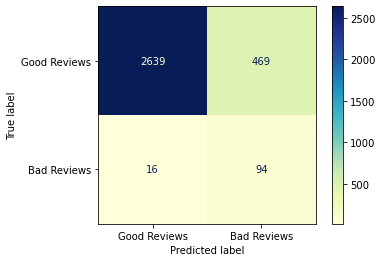

In [55]:
logic = LogisticRegression(solver='liblinear', penalty='l1', C=0.03)
logic.fit(X_train_over,y_train_over)
print(f'Accuracy Rate (train): {logic.score(X_train, y_train)}, Accuracy Rate (test): {logic.score(X_test, y_test)}')
print('')
metrics.plot_confusion_matrix(logic, X_test, y_test, cmap='YlGnBu', 
                              values_format='d', display_labels=['Good Reviews', 'Bad Reviews']);

In [57]:
y_true = y_test
y_pred = logic.predict(X_test)
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3108
           1       0.17      0.85      0.28       110

    accuracy                           0.85      3218
   macro avg       0.58      0.85      0.60      3218
weighted avg       0.97      0.85      0.89      3218



In [58]:
# put the selected features into a DataFrame
coefficients = pd.DataFrame(data=logic.coef_[0], index=X_train.columns, columns=['model_coefficient'])

# list the features of the non-zero coefficients 
coefficients[coefficients['model_coefficient']!=0]

,model_coefficient
nb_chars,-0.006584
nb_words,0.040079
compound,-3.194847
doc2vec_vector_0,1.741210
doc2vec_vector_1,1.799626
doc2vec_vector_2,-0.755671
doc2vec_vector_3,0.595323
doc2vec_vector_4,-1.824314
word_andrew,-1.032355
word_concept,-0.523176


In [59]:
# Misclassification Analysis(ACA)
mca_df = reviews.filter(X_test.index, axis=0)
mca_df['true_label'] = y_test
mca_df['predicted_label'] = logic.predict(X_test)
mca_df[(mca_df['true_label']==0)&(mca_df['predicted_label']==1)][['review','true_label','predicted_label']].head(10)

,review,true_label,predicted_label
840,"A good course so far , it introduces alot the theory about the material , and gives alot of advices on how and when to apply different algorithms , 4 stars because i think that submitting homeworks should be followed by some sort of explanations or solutions to the problems , even tho homworks are a little bit guided !",0,1
2341,"Good quality, one star taken away for the unsteady volume",0,1
2120,I would be much better if it would have included the more layman explanation.,0,1
469,"It is hard, without a doubt, and u most probably will take more time to finish each week, than you can think. But I think this is as complete as it gets. DO NOT depend on this course solely. Go on to Khan Academy and other sites, and learn how the maths work. Although I was familiar with calculus and did a lot of it. Keeping up with all the not...",0,1
2876,VERY GOOD,0,1
3451,"I learned a lot of concepts in an organized and structured manner in this course that I probably would have spent months trying to figure out on my own. Prof. Ng is one of the best teachers I have had, in spite of the fact that this was an online course. Thank you so much for providing these resources for the world to learn from. This is nothin...",0,1
742,"The course works well as an introductory course providing an overview of what machine learning is and what it involves.The instructor is didactic, the activities served to understand the process involved in the programming of machine learning systems. About the tests, I sometimes found the text a little confusing, but maybe it's because I'm not...",0,1
6442,I have been struggling to initiate Machine learning on my own.I was always fascinated by it but always failed in getting myself into the right framework and mood to learn ML.This course in particular has helped me a lot in understanding and getting into depth of areas of ML.I cannot thank enough Stand ford and Andrew Ng for this wonderful lesson.,0,1
2771,Very instructional!,0,1
2037,This course provides sufficient knowledge to understand a lot of jargon related to ML.,0,1


#### SMOTE (Synthetic Minority Over-sampling Technique)

In [60]:
smo = SMOTE(random_state=42)

X_train_smote, y_train_smote = smo.fit_resample(X_train, y_train)

print_sampling_stats(X_train, X_train_smote,
                     y_train, y_train_smote,
                     y_test)

Original dataset classes: Counter({0: 9359, 1: 293})
Resampled dataset classes: Counter({0: 9359, 1: 9359})

Test dataset classes still the same to model real world: Counter({0: 3108, 1: 110})

X_train shape (under/reg):  (18718, 2245) (9652, 2245)
y_train shape (under/reg):  (18718,) (9652,)
X_test shape, y_test shape:  (3218, 2245) (3218,)


In [61]:
y_train_smote.value_counts(normalize=True)

0    0.5
1    0.5
Name: review_is_bad, dtype: float64

Accuracy Rate (train): 0.8512225445503523, Accuracy Rate (test): 0.857986326911125



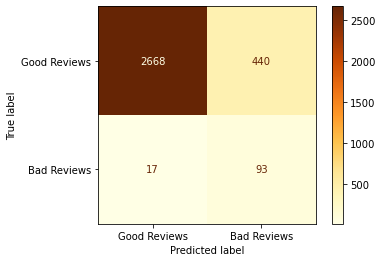

In [62]:
logic = LogisticRegression(solver='liblinear', penalty='l1', C=0.03)
logic.fit(X_train_smote,y_train_smote)
print(f'Accuracy Rate (train): {logic.score(X_train, y_train)}, Accuracy Rate (test): {logic.score(X_test, y_test)}')
print('')
metrics.plot_confusion_matrix(logic, X_test, y_test, cmap='YlOrBr', 
                              values_format='d', display_labels=['Good Reviews', 'Bad Reviews']);

In [66]:
y_true = y_test
y_pred = logic.predict(X_test)
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3108
           1       0.17      0.85      0.29       110

    accuracy                           0.86      3218
   macro avg       0.58      0.85      0.61      3218
weighted avg       0.97      0.86      0.90      3218



In [63]:
# put the selected features into a DataFrame
coefficients = pd.DataFrame(data=logic.coef_[0], index=X_train.columns, columns=['model_coefficient'])

# list the features of the non-zero coefficients 
coefficients[coefficients['model_coefficient']!=0]

,model_coefficient
nb_chars,-0.006653
nb_words,0.040371
compound,-3.908097
doc2vec_vector_0,1.915997
doc2vec_vector_1,2.187846
doc2vec_vector_2,-0.890301
doc2vec_vector_3,0.569796
doc2vec_vector_4,-1.950893
word_andrew,-0.011841
word_concept,-0.175658


In [64]:
# Misclassification Analysis(ACA)
mca_df = reviews.filter(X_test.index, axis=0)
mca_df['true_label'] = y_test
mca_df['predicted_label'] = logic.predict(X_test)
mca_df[(mca_df['true_label']==0)&(mca_df['predicted_label']==1)][['review','true_label','predicted_label']].head(10)

,review,true_label,predicted_label
840,"A good course so far , it introduces alot the theory about the material , and gives alot of advices on how and when to apply different algorithms , 4 stars because i think that submitting homeworks should be followed by some sort of explanations or solutions to the problems , even tho homworks are a little bit guided !",0,1
2341,"Good quality, one star taken away for the unsteady volume",0,1
2120,I would be much better if it would have included the more layman explanation.,0,1
469,"It is hard, without a doubt, and u most probably will take more time to finish each week, than you can think. But I think this is as complete as it gets. DO NOT depend on this course solely. Go on to Khan Academy and other sites, and learn how the maths work. Although I was familiar with calculus and did a lot of it. Keeping up with all the not...",0,1
2876,VERY GOOD,0,1
3451,"I learned a lot of concepts in an organized and structured manner in this course that I probably would have spent months trying to figure out on my own. Prof. Ng is one of the best teachers I have had, in spite of the fact that this was an online course. Thank you so much for providing these resources for the world to learn from. This is nothin...",0,1
742,"The course works well as an introductory course providing an overview of what machine learning is and what it involves.The instructor is didactic, the activities served to understand the process involved in the programming of machine learning systems. About the tests, I sometimes found the text a little confusing, but maybe it's because I'm not...",0,1
6442,I have been struggling to initiate Machine learning on my own.I was always fascinated by it but always failed in getting myself into the right framework and mood to learn ML.This course in particular has helped me a lot in understanding and getting into depth of areas of ML.I cannot thank enough Stand ford and Andrew Ng for this wonderful lesson.,0,1
2771,Very instructional!,0,1
2037,This course provides sufficient knowledge to understand a lot of jargon related to ML.,0,1


**Key takeways:** with adjusting class imbalance, the logistic model can outperform the baseline significantly.

In [65]:
# end of notebook